In [1]:
import pandas as pd
import numpy as np
import pickle
import pydotplus
import collections
from IPython.display import Image
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

from imblearn.over_sampling import SMOTE


In [2]:
# setting the file name
print("Loading the data...")
# file_dir = "D:\\...\\Data\\"
df = pd.read_csv(r"/Users/sathwikmadhusudan/Desktop/processed_data.csv")
print(df['class'].value_counts())
df = shuffle(df)
df['class'].value_counts()
print(f"Data loaded")

Loading the data...
class
critical       34974
transaction    25946
default        19773
OAM             2106
p2p             1619
control          993
video            379
signaling        113
bulk             111
VoIP              67
Name: count, dtype: int64
Data loaded


In [4]:
from sklearn.preprocessing import LabelEncoder
# Assume df is your DataFrame
x_names = ['protocol', 'src_port', 'dst_port', 'src2dst_packets', 'src2dst_bytes', 'dst2src_packets', 'dst2src_bytes']
y_name = ['class']

# processing input data
X = df[x_names]
X = np.asarray(X)

# processing output data
Y = df[y_name].values.ravel()  # Ensure Y is a 1d array
le = LabelEncoder().fit(Y)
Y = le.transform(Y)

# for debugging
print(np.shape(X), np.shape(Y))

# Splitting the dataset
x_train, x1_test, y_train, y1_test = train_test_split(X, Y, test_size=0.33, shuffle=True, random_state=42)

# applying SMOTE
smote = SMOTE(random_state=42)
X_sm, Y_sm = smote.fit_resample(X, Y)
print(np.shape(X_sm), np.shape(Y_sm))

# saving output data
dic = {}
for i in Y_sm:
    if i in dic.keys():
        dic[i] += 1
    else:
        dic[i] = 1
print(dic)


(86081, 7) (86081,)
(349740, 7) (349740,)
{8: 34974, 4: 34974, 5: 34974, 9: 34974, 0: 34974, 3: 34974, 6: 34974, 7: 34974, 1: 34974, 2: 34974}


In [5]:
# feature selection(use if necessary)
"""
SelectKBest(mutual_info_classif, k=3)
k=7 all
k=5 dst_port, src_dst_bytes, dst_src_bytes, protocol, src_des_packets
k=3 dst_port, src_dst_bytes, dst_src_bytes

SelectKBest(score_func=chi2, k=5)
k=7 all
k=5 dst_port, src_dst_bytes, dst_src_bytes, src_port, des_port
k=3 dst_port, src_dst_bytes, dst_src_bytes

"""
#X_new = SelectKBest(mutual_info_classif, k=5).fit_transform(X_sm, Y_sm)

# data splitting
print("Splitting the data")
x_train, x_test, y_train, y_test = train_test_split(X_sm, Y_sm, test_size=0.33, shuffle=True)
print("Data splitting done!")

Splitting the data
Data splitting done!


In [6]:
# training
print("Starting to train")
dtc = DecisionTreeClassifier(random_state=15, max_depth=11)
dtc.fit(x_train, y_train)
print(f"Classifer description\n{dtc}")
print("Testing the classifier")

y_pred = dtc.predict(x1_test)
print('accuracy %s' % accuracy_score(y1_test, y_pred))
print("Classes: ", le.inverse_transform([0,1,2,3,4,5,6,7,8,9]))
print(classification_report(y1_test, y_pred, target_names= le.inverse_transform([0,1,2,3,4,5,6,7,8,9]), labels=range(10)))
print("Saving the model")
filename = "decisiontree_model.sav"
pickle.dump(dtc, open(filename,'wb'))
print("Saved the model")


Starting to train
Classifer description
DecisionTreeClassifier(max_depth=11, random_state=15)
Testing the classifier
accuracy 0.960925124089133
Classes:  ['OAM' 'VoIP' 'bulk' 'control' 'critical' 'default' 'p2p' 'signaling'
 'transaction' 'video']
              precision    recall  f1-score   support

         OAM       0.99      1.00      0.99       691
        VoIP       0.06      0.91      0.11        22
        bulk       0.19      0.97      0.31        33
     control       0.99      0.99      0.99       337
    critical       1.00      1.00      1.00     11563
     default       1.00      0.91      0.95      6505
         p2p       0.69      0.98      0.81       531
   signaling       0.46      0.97      0.62        36
 transaction       0.99      0.95      0.97      8555
       video       0.32      0.93      0.47       134

    accuracy                           0.96     28407
   macro avg       0.67      0.96      0.72     28407
weighted avg       0.98      0.96      0.97     

In [8]:
# Create DOT data
dot_data = export_graphviz(dtc, out_file="network_decision_tree.dot",
                                feature_names=x_names,
                                class_names= le.inverse_transform([0,1,2,3,4,5,6,7,8,9]),
                                rounded= True,
                                filled=True
                                )

"""# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())"""




'# Draw graph\ngraph = pydotplus.graph_from_dot_data(dot_data)\n\n# Show graph\nImage(graph.create_png())'

In [12]:
!dot -Tpng network_decision_tree.dot -o network_decision_tree.png


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.318953 to fit


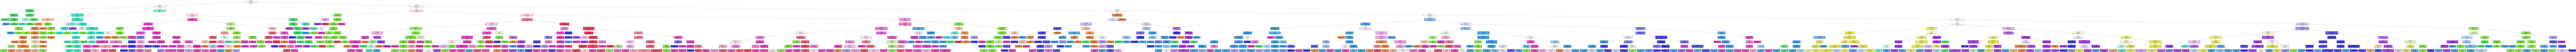

In [13]:
from IPython.display import Image
Image(filename='network_decision_tree.png')

In [18]:
import itertools
#confusion matrix graph

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[  689     0     0     0     0     1     0     0     1     0]
 [    0    20     0     0     0     1     0     1     0     0]
 [    0     0    32     0     0     1     0     0     0     0]
 [    0     0     0   333     3     1     0     0     0     0]
 [    0    40     0     1 11509    13     0     0     0     0]
 [    7   269   110     1     1  5936    95    37    49     0]
 [    1     0     0     0     0     3   519     0     7     1]
 [    0     0     0     0     0     1     0    35     0     0]
 [    2    12    30     0     0     6   138     3  8100   264]
 [    0     0     0     0     0     0     0     0    10   124]]
[[10, 0, 0, 0], [0, 9, 1, 0], [0, 0, 9, 0], [0, 0, 1, 8]]
Normalized confusion matrix


/var/folders/8w/96rv308138b_1rxr1ndf_2880000gn/T/ipykernel_83125/3616304530.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


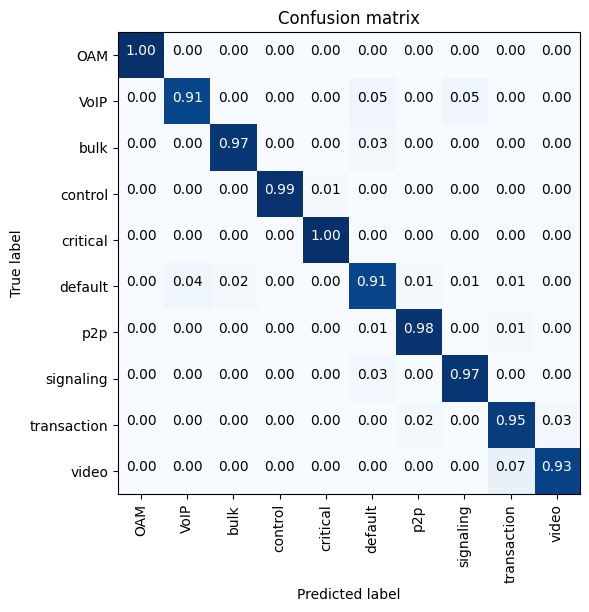

In [17]:
# confusion matrix
import itertools
fig = plt.figure()
fig.set_size_inches(6, 6, forward=True)
fig.align_labels()

#fig.subplots_adjust(left=-3.0, right=-2.0, bottom=0.0, top=1.0)
print(confusion_matrix(y1_test, y_pred))

cm = [
    [10,0,0,0],
    [0,9,1,0],
    [0,0,9,0],
    [0,0,1,8]
]

print(cm)
plot_confusion_matrix(confusion_matrix(y1_test, y_pred), normalize=True,
                      title='Confusion matrix', classes= le.inverse_transform([0,1,2,3,4,5,6,7,8,9]))
fig.show()
fig.savefig(str('7')+"_cm_dt.png")